In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("IMDB-Dataset.csv")
df = df.drop_duplicates()
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Data cleaning

In [5]:
import contractions

In [6]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):

    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text, "html.parser") # Removing html tags

    text = soup.get_text()
    text = expand_contractions(text) # Expanding chatwords and contracts clearing contractions
    emoji_clean = re. compile ("["
                            u"\ U0001F600 -\ U0001F64F " # emoticons
                            u"\ U0001F300 -\ U0001F5FF " # symbols & pictographs
                            u"\ U0001F680 -\ U0001F6FF " # transport & map symbols
                            u"\ U0001F1E0 -\ U0001F1FF " # flags (iOS)
                            u"\ U00002702 -\ U000027B0 "
                            u"\ U000024C2 -\ U0001F251 "
                            "]+", flags =re. UNICODE )
    text = emoji_clean.sub(r'',text )
    text = re.sub (r'\.(?=\ S)', '.',text ) #add space after full stop
    text = re.sub (r'http \S+', '', text ) # remove urls
    text = "". join ([
            word.lower() for word in text if word not in string.punctuation]) # remove punctuation and make text lowercase
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) # lemmatize
    return text

df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Dell\AppData\Local\Temp\ipykernel_3844\3618827230.py:21: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") # Removing html tags


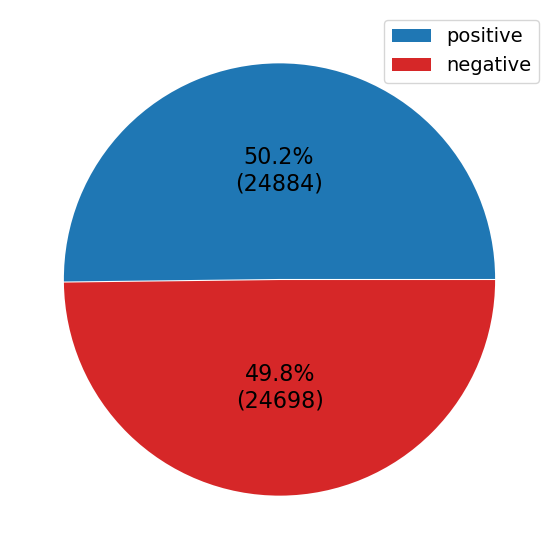

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Calculate frequencies
freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]
labels = ['positive', 'negative']

# Create pie chart
fig, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025] * 2,
        pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize': 16})

# Add legend
plt.legend(labels, loc="best", prop={'size': 14})

# Save and show the pie chart
fig.savefig("PieChart.png")
plt.show()


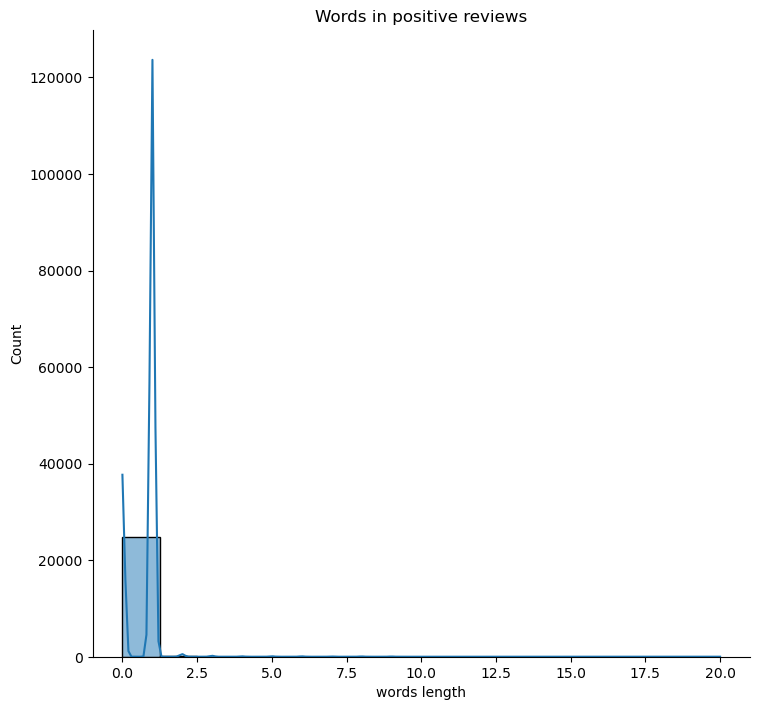

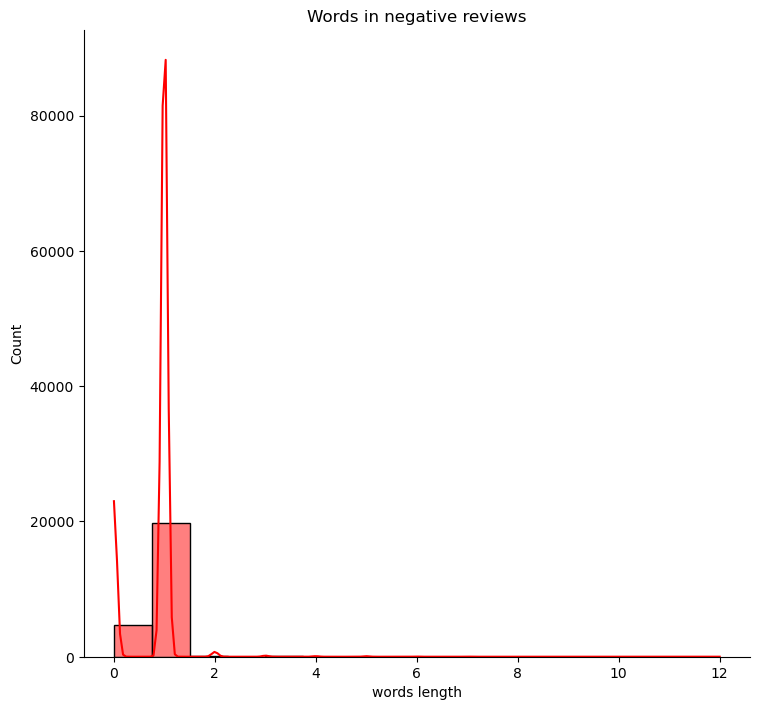

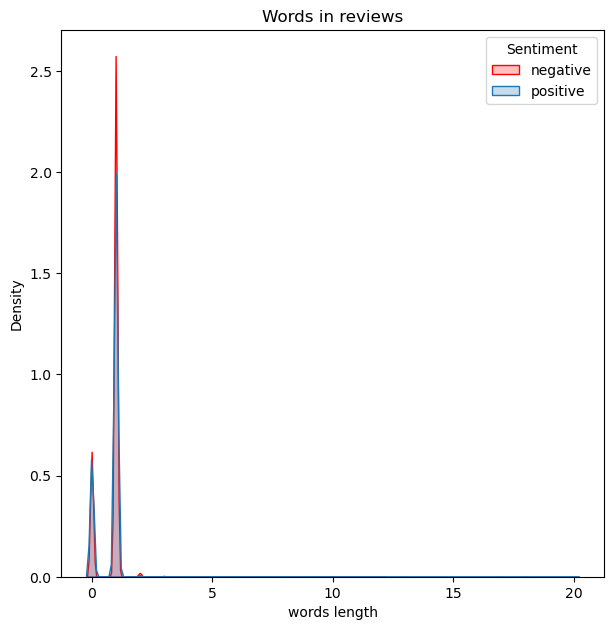

In [10]:
# Calculate the length of words in each review
words_len = df['review'].str.split().map(lambda x: len(x))

# Create a copy of the DataFrame and add 'words length' column
df_temp = df.copy()
df_temp['words length'] = words_len

# Plot the distribution of words in positive reviews
hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show(hist_positive)

# Plot the distribution of words in negative reviews
hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title='Words in negative reviews')
plt.show(hist_negative)

# Plot kernel density distribution of word counts across all reviews
plt.figure(figsize=(7, 7.1))
kernel_distribution_plot = sns.kdeplot(
    data=df_temp, x="words length", hue="sentiment", fill=True, palette=[sns.color_palette()[0], 'red']
).set(title='Words in reviews')

# Add legend to the plot
plt.legend(title='Sentiment', labels=['negative', 'positive'])

# Show the kernel density plot
plt.show(kernel_distribution_plot)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

x_data = df['review']
# Encode sentiment labels
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)


In [13]:
# Initialize the TF-IDF vectorizer with a maximum of 10,000 features
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Fit the vectorizer on the training data (only on x_train, not y_train)
tfidf_vectorizer.fit(x_train)

# Transform the training and test data using the fitted TF-IDF vectorizer
x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

# Train the classifier on the encoded training data
dt_classifier.fit(x_train_encoded, y_train)

# Predict using the test data
y_pred = dt_classifier.predict(x_test_encoded)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.5020


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(
    random_state=42
)

# Train the classifier on the encoded training data
rf_classifier.fit(x_train_encoded, y_train)

# Predict using the test data
y_pred = rf_classifier.predict(x_test_encoded)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.5020
